**Semester final project – Jednotné programovacie družstvo a.s.**

This source code accumulates all the results and analyses obtained during the solving of the given project on summer semester course **Metódy voľnej optimalizácie** at the **Faculty of Mathematics, Physics and Informatics of Comenius University in Bratislava**.

On behalf of the **Jednotné programovacie družstvo a.s.**:



*   Lucia Ganajová
*   Tuan Dávid Nguyen Van
*   Jakub Novotný
*   Marek Šugár



In [ ]:
#pip install selenium

In [ ]:
# Import of libraries
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import folium
from shapely.geometry import Point

import io
from PIL import Image
# import selenium
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

## **Task A:**

***Definitions and Jacobian matrix.***

In the next few cells **radar coordinates**, **distances**, particular functions $f_i$, vector function **$F$** and **$\|F\|_{2}^2$** are defined.

*   `a` - array of 2D **radar coordinates**
*   `d` - **measured distances** from radars



In [ ]:
# Radars coordinates 2D
a = np.array([
      [1.5, 1.5],
      [1.5, 2],
      [2, 1.75],
      [1.8, 2.5],
      [2.5, 1.6]
    ])

# Mesured distances from radars (corresponds to the index)
d = np.array([0.75, 1.2, 1.25, 1.75, 1.6])

Function `f(x, i)` returns $f_i(x)=\|x - a_i\| - d_i$, which is a particular function of $F$.

In [ ]:
# Definitions of particular f_i functions
def f(x,i):
  return norm(x-a[i]) - d[i]

`F(x)` function returns vector of particular funcitons:

\begin{equation}
    F=\begin{bmatrix}
        f_1 \\
        f_2 \\
        \vdots \\
        f_5 \\
    \end{bmatrix}
\end{equation}

and `F_22(x)` returns $\|F(x)\|_2^2$.

In [ ]:
# Definition of F vector of f_i's
def F(x):
  return np.array([f(x,i) for i in range(len(a))])

def F_22(x):
  return norm(F(x))**2

**Jacobian matrix**

`jacobi_matrix(x)` returns the **numerical value** of the Jacobian matrix

\begin{equation}
    DF(x)=\begin{bmatrix}
        \nabla f_1^T \\
        \nabla f_2^T \\
        \vdots \\
        \nabla f_5^T \\
    \end{bmatrix}
    = \begin{bmatrix}
        \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} \\[6pt]
        \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} \\[6pt]
        \vdots & \vdots\\[6pt]
        \frac{\partial f_5}{\partial x_1} & \frac{\partial f_5}{\partial x_2} \\
    \end{bmatrix}
     =
    \begin{bmatrix}
        \frac{x_1-a_1^1}{\|x-a_1\|_2} & \frac{x_2-a_1^2}{\|x-a_1\|_2} \\[6pt]
        \frac{x_1-a_2^1}{\|x-a_2\|_2} & \frac{x_2-a_2^2}{\|x-a_2\|_2} \\[6pt]
        \vdots & \vdots \\
        \frac{x_1-a_5^1}{\|x-a_5\|_2} & \frac{x_2-a_5^2}{\|x-a_5\|_2} \\[6pt]
    \end{bmatrix}
\end{equation}


derived from the $F(x)$.

In [ ]:
def jacobi_matrix(x):
  '''
  Function returns the numerical value of Jacobian matrix derived from the F(x) as for gradients f_i(x)
  '''
  return np.array([
      (x-a[i]) / norm(x-a[i])
      for i in range(len(a))
  ])

---

## **Task B:**

***Visualisation of the function.***

### **Contour plot**

***A 2D contour plot of contour lines of a function $\|F\|_2^2$ and satellite coordinates $a_i$.***

In [ ]:
x_vals = np.linspace(0, 3, 100)
y_vals = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x_vals, y_vals)
# Initialisation of Z
Z = np.zeros_like(X)
Z2 = np.zeros_like(X)

# Loop through each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])  # (x1, x2) from meshgrid
        Z[i, j] = F_22(x) # Compute norm^2 of F(x)
        Z2[i, j] = norm(F(x))   # Compute norm of F(x)

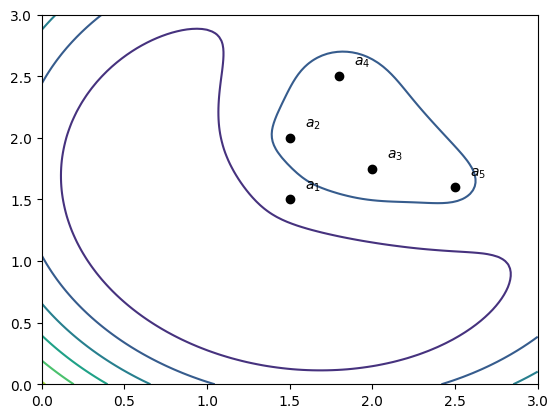

In [ ]:
# Countour plot of objective function ||F(x)||^2
plt.contour(X, Y, Z)
count = 1
for x,y in a:
  plt.scatter(x, y, color="black")
  plt.text(x + 0.09, y + 0.09, f"$a_{count}$")
  count += 1

### **3D plot of $\|F\|_2$**

Text(0.5, 0.5, '$x_2$')

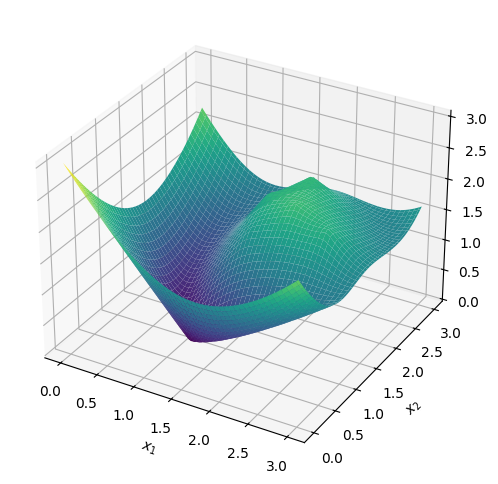

In [ ]:
# 3D Plot of objective function ||F(x)||_2
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z2, cmap='viridis')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

---

## **Task C:**

***Levenberg-Marquardt optimisation method.***

The Levenberg–Marquardt method assumes that

$g_{k}=DF(x^{k})F(x^{k})$

$s_{k}=-H_{k}^{-1}g_{k} = -(DF(x^{k})^{T}DF(x^{k}) + \mu^{k}I)^{-1} DF(x^{k})^{T} F(x^{k}) $,

where $g_k$ corresponds to the **gradient in k-th iteration** and $s_k$ corresponds to the **direction vector in k-th iteration**. $H_k$ is Hessian matrix approximation.

### **Algorithm structure**

This implementation of the **Levenberg–Marquardt algorithm** solves a nonlinear least squares problem in two dimensions.

**Input parameters:**
- `x0` — initial 2D point
- `mi0` — initial damping parameter $ \mu_0 $
- `epsilon` — tolerance for convergence $ \varepsilon $
- `k_max` — maximum number of iterations allowed
- `function` — objective function to be minimized

**The function `LM` returns:**
- `xk` — final approximation of the solution (2D NumPy array)
- `iterations_mi` — dictionary storing the value of the damping parameter $ \mu^k $ at each iteration (keys = iteration number, values = $ \mu^k $)
- `iterations_value` — dictionary storing the value of the objective function $ \|F(x^k)\|_2^2 $ at each iteration
- `iterations` — list of all iterated points $ x^k $ visited during the optimization process



**Levenberg–Marquardt pseudo-algorithm:**

1. Compute $F(x^k)$, the Jacobian $DF(x^k)$, and the gradient $g_k = DF(x^k)^T F(x^k)$.
2. If $\|F(x^k)\|_2 < \varepsilon$ or $\|g_k\|_2 < \frac{\varepsilon}{2}$, terminate.
3. Compute the approximate Hessian $H_k = DF(x^k)^T DF(x^k) + \mu_k I$.
4. Solve the linear system $H_k s_k = -g_k$ for the update direction $s_k$.
5. Compute the candidate next point $x^{k+1} = x^k + s_k$.
6. If $\|F(x^{k+1})\|_2 < \|F(x^k)\|_2$, update the damping parameter: $\mu^{k+1} = 0.8 \mu^k$ and accept the step.
7. Otherwise, reject the step, set $\mu^k = 2 \mu_k$, and keep $x^{k+1} = x_k$.
8. Increment $k$ and repeat from step 1.

In [ ]:
def LM(x0, mi0, epsilon, k_max, function=F_22):
  '''
    Levenberg-Marquardt algorithm

    Parameters:
    x0       : Starting point (2D)
    mi0      : Initial damping parameter
    epsilon  : Tolerance for convergence
    k_max    : Maximum number of iterations
    function : Function to be minimized (default is F_22)

    Returns:
    xk       : Final point after optimization
  '''
  xk = x0
  mi_k = mi0
  iterations_mi = {}
  iterations_value = {}
  iterations = []

  for k in range(k_max):
    iterations_mi[k] = mi_k
    iterations_value[k] = function(xk)
    iterations.append(xk)

    DFk = jacobi_matrix(xk)
    H_k = DFk.T @ DFk + mi_k*np.identity(2)
    g_k = DFk.T @ F(xk)
    if norm(F(xk)) < epsilon or norm(2*g_k) < epsilon:
      break
    else:
      sk = np.linalg.solve(H_k, -g_k)
      x_k1 = xk + sk

      if norm(F(x_k1))**2 < norm(F(xk))**2:
        mi_k = 0.8*mi_k
        xk = x_k1
      else:
        mi_k = 2*mi_k

  return xk, iterations_mi, iterations_value, iterations

In [ ]:
# Various data about every single iterations performed for given x_0's
iter1 = LM(x0=np.array([2.2, 3.5]), mi0=0.1, epsilon=1e-6, k_max=1000)
iter2 = LM(x0=np.array([1.8, 3.5]), mi0=0.1, epsilon=1e-6, k_max=1000)
iter3 = LM(x0=np.array([3, 1.5]), mi0=0.1, epsilon=1e-6, k_max=1000)

In [ ]:
F_22(iter1[0])

np.float64(1.8275306828883784)

---

## **Task D:**

***The behavior of the objective function value $ \|F(x^k)\|_2^2 $ and the damping parameter $ \mu_k $ across iterations $ k = 1, 2, 3, \ldots $.***


### **Behaviour of mi_k with respect to the iteration number**

Text(0, 0.5, 'Hodnota $\\mu_{k}$')

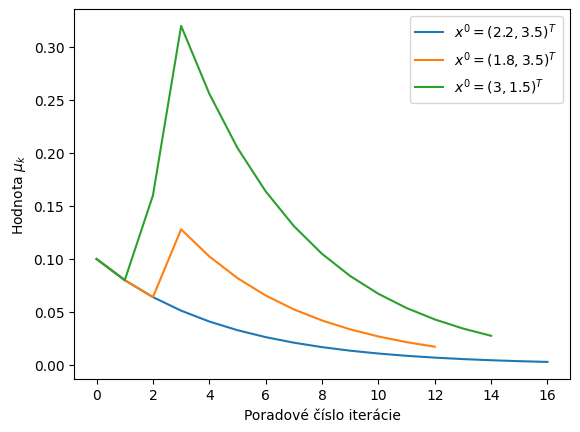

In [ ]:
# Task d) -> Behaviour of mi_k with respect to the iteration number
plt.plot(iter1[1].keys(), iter1[1].values())
plt.plot(iter2[1].keys(), iter2[1].values())
plt.plot(iter3[1].keys(), iter3[1].values())

plt.legend(["$x^{0}=(2.2, 3.5)^T$", "$x^{0}=(1.8, 3.5)^T$", "$x^{0}=(3, 1.5)^T$"])
plt.xlabel("Poradové číslo iterácie")
plt.ylabel("Hodnota $\mu_{k}$")

### **Behaviour of objective function value with respect to the iteration number**

Text(0, 0.5, 'Hodnota $||F(x)||_{2}^{2}$')

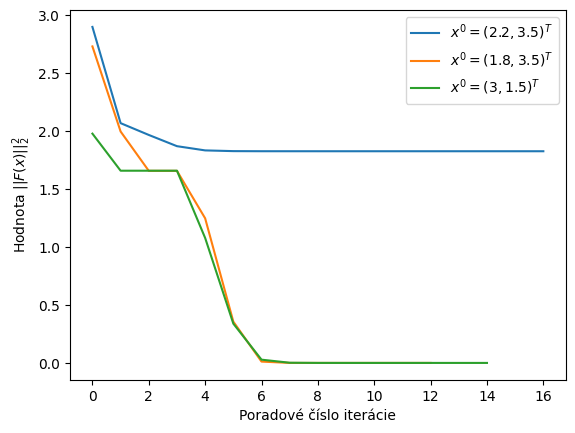

In [ ]:
# Task d) -> Behaviour of objective function value with respect to the iteration number
plt.plot(iter1[2].keys(), iter1[2].values())
plt.plot(iter2[2].keys(), iter2[2].values())
plt.plot(iter3[2].keys(), iter3[2].values())

plt.legend(["$x^{0}=(2.2, 3.5)^T$", "$x^{0}=(1.8, 3.5)^T$", "$x^{0}=(3, 1.5)^T$"])
plt.xlabel("Poradové číslo iterácie")
plt.ylabel("Hodnota $||F(x)||_{2}^{2}$")

### **Contour plot for convergence of the method using 3 different starting points**

In [ ]:
x_vals = np.linspace(0, 4, 100)
y_vals = np.linspace(0, 4, 100)
X, Y = np.meshgrid(x_vals, y_vals)
# Initialisation of Z
Z = np.zeros_like(X)
Z2 = np.zeros_like(X)

# Loop through each point in the grid
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])  # (x1, x2) from meshgrid
        Z[i, j] = norm(F(x))**2 # Compute norm^2 of F(x)
        Z2[i, j] = F_22(x)   # Compute norm of F(x)

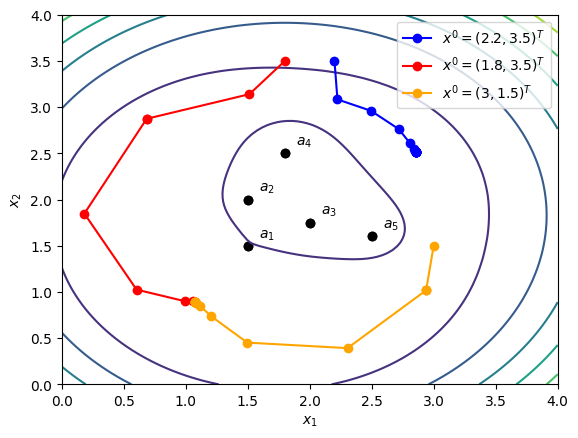

In [ ]:
plt.contour(X, Y, Z)

x1_vals_1, x2_vals_1 = zip(*iter1[3])
plt.plot(x1_vals_1, x2_vals_1, "o-", color="blue")

x1_vals_2, x2_vals_2 = zip(*iter2[3])
plt.plot(x1_vals_2, x2_vals_2, "o-", color="red")

x1_vals_3, x2_vals_3 = zip(*iter3[3])
plt.plot(x1_vals_3, x2_vals_3, "o-", color="orange")

count = 1
for x,y in a:
  plt.scatter(x, y, color="black")
  plt.text(x + 0.09, y + 0.09, f"$a_{count}$")
  count += 1

plt.legend(["$x^{0}=(2.2, 3.5)^T$", "$x^{0}=(1.8, 3.5)^T$", "$x^{0}=(3, 1.5)^T$"])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

for x,y in a:
  plt.scatter(x, y, color="black")

### **3D plot for convergence of the method using 3 different starting points**

In [ ]:
x_vals = np.linspace(0, 3, 100)
y_vals = np.linspace(0, 3.6, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)
Z2 = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        Z[i, j] = norm(F(x))**2
        Z2[i, j] =norm(F(x))

def trace_from_iter(pts, color, name):
    arr = np.array(pts)
    zs = np.array([norm(F(p))**2+0.1 for p in arr])
    return go.Scatter3d(
        x=arr[:,0], y=arr[:,1], z=zs,
        mode='lines+markers',
        marker=dict(size=4, color=color),
        line=dict(width=2, color=color),
        name=name
    )

fig = go.Figure()

fig.add_trace(
    go.Surface(
        x=X, y=Y, z=Z,
        colorscale='Viridis',
        opacity=0.7,
        showscale=False,
        name='‖F(x)‖²'
    )
)

fig.add_trace(trace_from_iter(iter1[3], 'blue',  r"$x^0=(2.2,3.5)^T$"))
fig.add_trace(trace_from_iter(iter2[3], 'red',   r"$x^0=(1.8,3.5)^T$"))
fig.add_trace(trace_from_iter(iter3[3], 'orange',r"$x^0=(3.0,1.5)^T$"))

fig.update_layout(
    width=900,
    height=900,
    scene=dict(
        xaxis_title='x₁',
        yaxis_title='x₂',
        zaxis_title='z'
    )

)


---

## **Task E:**

***Simplified model of GPS navigation.***

In the next few cells **satellite coordinates** $s_i$, **times when the signal from them was sent**, **particular $f_i$ functions**, **vector $F$** and **Jacobi matrix** are defined.

*   `s` - vector of satellite coordinates on 3D
*   `t_i` - time of signal transmission

In [ ]:
# Satellite coords
s = np.array([
    [1, 2, 0],
    [2, 0, 2],
    [1, 1, 1],
    [2, 1, 0]
    ])

# time 1 - 4
t_i = np.array([19.9,2.4,32.6,19.9])

Function `f1` takes 3 parameters:
*  `x` - the point x where the function is being evaluated (3D)
*  `t` - another dimension - time (1D) where function is being evaluated
*  `i` - index of `s` and `t_i`

and returns the value of $\|x - s_i\|_2 - 0.047(t-t_i)$.


In [ ]:
# Definitions of particular fi_1 functions
def f1(x,t,i):
  return norm(x - s[i]) - 0.047*(t - t_i[i])

Function `F_2` takes only 1 parameter - vector `x` $ = [x_1, x_2, x_3, t]$ and returns vector of numerical values for the particular functions $f_i$ using function `f1` in indexes $1, 2, 3, 4$ (`len(s)`)

\begin{equation}
    F=\begin{bmatrix}
        f_1\\
        f_2\\
        f_3\\
        f_4
    \end{bmatrix}
\end{equation}

Function `F2_2` returns the numerical value of $\|F(x)\|_2^2$.

In [ ]:
# Definition of F vector of f_i's
def F_2(x):
  x, t = x[0:3], x[3]
  return np.array([
    f1(x, t,i) for i in range(len(s))
  ])

def F2_2(x):
  return norm(F_2(x))**2

**Jacobian Matrix**

Function `jacobi_4_4` computes Jacobi matrix for the function $F$

\begin{equation}
    DF(x)=\begin{bmatrix}
        \frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \frac{\partial f_1}{\partial x_3} & \frac{\partial f_1}{\partial t} \\
        \frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \frac{\partial f_2}{\partial x_3} & \frac{\partial f_2}{\partial t} \\
        \vdots & \vdots & \vdots & \vdots \\
        \frac{\partial f_4}{\partial x_1} & \frac{\partial f_4}{\partial x_2} & \frac{\partial f_4}{\partial x_3} & \frac{\partial f_4}{\partial t} \\
    \end{bmatrix}
 =
 \begin{bmatrix}
        \frac{x_1-s_1^1}{\|x-s_1\|_2} & \frac{x_2-s_1^2}{\|x-s_1\|_2} &\frac{x_3-s_1^3}{\|x-s_1\|_2} & 0.047 \\
        \frac{x_1-s_2^1}{\|x-s_2\|_2} & \frac{x_2-s_2^2}{\|x-s_2\|_2} &\frac{x_3-s_2^3}{\|x-s_2\|_2} & 0.047 \\
        \vdots & \vdots & \vdots & \vdots \\
        \frac{x_1-s_4^1}{\|x-s_4\|_2} & \frac{x_2-s_4^2}{\|x-s_4\|_2} &\frac{x_3-s_4^3}{\|x-s_4\|_2} & 0.047 \\
    \end{bmatrix}
\end{equation}

`jacobi_4_4` takes one argument - vector `x` $= [x_1, x_2, x_3, t]$, at which the Jacobian matrix is being computed.

In [ ]:
def jacobi_4_4(x):
  x = x[0:3]
  return np.array([
      [*list((x - s[i]) / norm(x - s[i])),-0.047]
      for i in range(len(s))
  ])

### **Levenberg-Marquardt algorithm for simplified GPS**

**Function:** `less_difficulty_GPS`

This function is a specific implementation of the **Levenberg–Marquardt** method applied to a 4-dimensional variant of the nonlinear least squares problem related to GPS modeling.

**Input parameters:**
- `x0` – 4D starting point $ x_0 = [x_1, x_2, x_3, t] $
- `mi0` – initial damping parameter $ \mu_0 $
- `epsilon` – convergence tolerance $ \varepsilon $
- `k_max` – maximum number of iterations
- `function` – objective function to be minimized (default: `F2_2`)

**Returns:**
- `xk` – final point found by the algorithm (4D vector)
- `iterations_mi` – dictionary of damping parameters $ \mu_k $ at each iteration
- `iterations_value` – dictionary of objective function values $ \|F(x_k)\|^2 $
- `iterations` – list of all iterated points $ x_k $

This version uses a $ 4 \times 4 $ Jacobian matrix computed via `jacobi_4_4(x)` and a corresponding identity matrix in the computation of the approximate Hessian $ H_k $. The vector function `F_2(x)` is assumed to return residuals for the 4D case.



In [ ]:
def less_difficulty_GPS(x0, mi0, epsilon, k_max, function=F2_2):
  '''
    Levenberg-Marquardt algorithm

    Parameters:
    x0       : Starting point (4D)
    mi0      : Initial damping parameter
    epsilon  : Tolerance for convergence
    k_max    : Maximum number of iterations
    function : Function to be minimized (default is F2_2)

    Returns:
    xk       : Final point after optimization
  '''
  xk = x0
  mi_k = mi0
  iterations_mi = {}
  iterations_value = {}
  iterations = []

  for k in range(k_max):
    iterations_mi[k] = mi_k
    iterations_value[k] = function(xk)
    iterations.append(xk)

    DFk = jacobi_4_4(xk)
    H_k = DFk.T @ DFk + mi_k*np.identity(4) # 4x4 identity
    g_k = DFk.T @ F_2(xk)
    if norm(F_2(xk)) < epsilon or norm(2*g_k) < epsilon:
      break
    else:
      sk = np.linalg.solve(H_k, -g_k)
      x_k1 = xk + sk

      if norm(F_2(x_k1))**2 < norm(F_2(xk))**2:
        mi_k = 0.8*mi_k
        xk = x_k1
      else:
        mi_k = 2*mi_k

  return xk, iterations_mi, iterations_value, iterations

In [ ]:
iteration1 = less_difficulty_GPS(x0=np.array([3000, -30000, 30000, 39]), mi0=0.1, epsilon=1e-6, k_max=1000) # OK
iteration2 = less_difficulty_GPS(x0=np.array([5000, 3000, 30000, 30]), mi0=0.1, epsilon=1e-6, k_max=1000) # NOT OK
iteration3 = less_difficulty_GPS(x0=np.array([0, 0, 0, 50]), mi0=0.1, epsilon=1e-6, k_max=1000) # OK
iteration4 = less_difficulty_GPS(x0=np.array([1, 11, 111, 1111]), mi0=0.1, epsilon=1e-6, k_max=1000) # NOT OK
iteration5 = less_difficulty_GPS(x0=np.array([300, -2000, 300, 2]), mi0=0.1, epsilon=1e-6, k_max=1000) # OK

---

## **Task F:**

***The actual location of the GPS device.***

### **Coordinate Conversion – Cartesian to Ellipsoidal**

This function estimates the geodetic position (latitude, longitude, and altitude) of a GPS device based on its Cartesian coordinates $(x_1, x_2, x_3)$
 The conversion is based on the ***Airy 1830*** ellipsoid model. The algorithm first converts coordinates from a normalized form to meters, and then uses an iterative method to estimate the latitude

**Function:** `convert`

**Inputs:**

* `x1, x2, x3` -  Cartesian coordinates

* `a` -  equatorial radius

* `b` -  polar radius

**Returns:**

* `latitude` in degrees

* `longitude` in degrees

* `altitude` above the 0 level of ellipsoid in meters

**Algorithm**

* `longitude` can be easily obtained as $λ = arctan(x_1/x_2)$.
* `latitude` is calculated using the following iterative algorithm:
    - $\psi_0 = \arctan\left( \frac{x_3}{p(1 - e)} \right)$
    - $v_0 = \frac{a}{\sqrt{1 - e \cdot \sin^2(\psi_0)}}$
    - $\psi_i = \arctan\left( \frac{x_3 + e \cdot v_{i-1} \cdot \sin(\psi_{i-1})}{p} \right), \quad i = 1, 2, 3, \dots$
    - $v_i = \frac{a}{\sqrt{1 - e \cdot \sin^2(\psi_i)}}, \quad i = 1, 2, 3, \dots$

  where:
      
    - $e = \frac{a^2 - b^2}{a^2}$
    - $p = \sqrt{x_1^2 + x_2^2}$
* `altitude` is then easily obtained as
 $\frac{p}{cos(\psi) - v_{n}}$, where $n$ is number of iterations



In [ ]:
def convert(x1, x2, x3, a=6377563.396, b=6356256.909):
  R = a

  # to meters
  x1, x2, x3 = R*x1, R*x2, R*x3

  e = (a**2 - b**2) / a**2
  p = np.sqrt(x1**2 + x2**2)

  psi = np.arctan2(x3, p * (1 - e))
  v = a / np.sqrt(1 - e * np.sin(psi)**2)

  for i in range(5):
    eq = (x3 + e * v * np.sin(psi))
    psi = np.arctan2(eq,p)
    v = a / np.sqrt(1 - e * np.sin(psi)**2)

  v = a / np.sqrt(1 - e * np.sin(psi)**2)
  lam = np.arctan2(x1,x2)

  altitude = p / np.cos(psi) - v
  latitude = np.degrees(psi)
  longitude = np.degrees(lam)

  return latitude, longitude, altitude

In [ ]:
convert(*less_difficulty_GPS(x0=np.array([0, 0, 0, 50]), mi0=0.1, epsilon=1e-6, k_max=1000)[0][:3])

(np.float64(19.551536787173212),
 np.float64(44.99887790980739),
 np.float64(-1921.428428024985))

In [ ]:
convert(*less_difficulty_GPS(x0=np.array([3000, -30000, 30000, 39]), mi0=0.1, epsilon=1e-6, k_max=1000)[0][:3])

(np.float64(19.551721341370403),
 np.float64(45.00026412791655),
 np.float64(-1103.537386140786))

In [ ]:
display(norm(less_difficulty_GPS(x0=np.array([-600,-10,-20, 15]), mi0=0.1, epsilon=1e-6, k_max=1000)[0][:3]))
convert(*less_difficulty_GPS(x0=np.array([-600,-10,-20, 15]), mi0=0.1, epsilon=1e-6, k_max=1000)[0][:3])


np.float64(0.9995112408867501)

(np.float64(19.55180268720378),
 np.float64(45.00086028073792),
 np.float64(-748.5069840764627))

---

## **Tasks G:**

***Further modifications of the project.***

### **General 2D Optimization using Levenberg–Marquardt Algorithm**

This function estimates the unknown 2D position of an object based on its distances from multiple known radar locations.

**Function** `general_2D`

**Input parameters:**

* `radar_coordinates` - a list of 2D coordinates representing radar positions
* `radar_distances` - a list of measured distances from each radar to the unknown object
* `starting_point` -  starting point for the method (initial guess for the position - 2D vector)
* `epsilon` - convergence threshold for stopping
* `iterations_max` -  maximum number of allowed iterations

**Returns**

* `xk` -  estimated 2D position of the object
* `iterations_mi` - dictionary of damping parameter values over iterations
* `iterations_value` - dictionary of objective function values per iteration
* `iterations` - list of 2D points visited during optimization



In [ ]:
def general_2D(radar_coordinates, radar_distances, starting_point, epsilon, iterations_max=500):
  '''
  General purpose optimization using Levenberg-Marquardt algorithm

  radar_coordinates : List of radar coordinates (2D)
  radar_distances   : List of radar distances data
  starting_point    : Starting point (2D)
  epsilon           : Tolerance for convergence
  '''
  # Input data validity
  if len(radar_coordinates) != len(radar_distances):
      raise Exception("Radar coordinates and distances must have the same length")

  if epsilon <= 0:
      raise Exception("Epsilon must be positive")

  if iterations_max <= 0:
      raise Exception("Iterations max must be positive")

  def function(x, radar_coordinate, radar_distance):
    '''
    Scalar residual function f_i, returns value of f_i for specific radar

    radar_coordinate : Radar coordinate (2D)
    radar_distance   : Radar distance data
    '''
    return norm(x - radar_coordinate) - radar_distance

  # List of scalar residual functions
  functions = [
        lambda x, radar=radar_coordinates[i], dist=radar_distances[i]: function(x, radar, dist)
        for i in range(len(radar_distances))
              ]

  # Vector-valued function of f_i's
  def F(x):
    '''
    Vector-valued function F, returns value of f_i for all radars
    '''
    return np.array([f(x) for f in functions])

  # Squared norm of F
  def F_norm(x):
    '''
    Squared norm of residuals, returns value of ||F(x)||^2 -> objective function
    '''
    return norm(F(x))**2

  # Jacobi matrix n*2 dimensions
  def jacobi_matrix(x):
    '''
    Jacobian matrix, returns value of Jacobian matrix at x of F
    '''
    J = []
    for radar in radar_coordinates:
      diff = x - radar
      J.append(diff / norm(diff))
    return np.array(J)

  def optimization(starting_point, epsilon, mu, iterations_max):
    '''
    Levenberg-Marquardt optimization

    starting_point : Starting point (2D)
    epsilon        : Tolerance for convergence
    mu             : Initial damping parameter
    iterations_max : Maximum number of iterations
    '''
    # Initial phase
    xk = starting_point
    mi_k = mu

    # Iterations tracking lists/dicts
    iterations_mi = {}
    iterations_value = {}
    iterations = []

    for k in range(iterations_max):
      iterations_mi[k] = mi_k
      iterations_value[k] = F_norm(xk)
      iterations.append(xk.copy())

      DFk = jacobi_matrix(xk)
      fk = F(xk)
      H_k = DFk.T @ DFk + mi_k * np.identity(2)
      g_k = DFk.T @ fk

      # Check stopping conditions
      if norm(fk) < epsilon or norm(2 * g_k) < epsilon:
        break

      # Step length
      sk = np.linalg.solve(H_k, -g_k)
      x_k1 = xk + sk

      if F_norm(x_k1) < F_norm(xk):
          mi_k *= 0.8
          xk = x_k1
      else:
        mi_k *= 2
    return xk, iterations_mi, iterations_value, iterations

  return optimization(starting_point, epsilon, 1e-6, iterations_max)

### **General 3D Optimization using Levenberg–Marquardt Algorithm**

This function, similarly to the 2D case, estimates the unknown 3D position of an object based on its distances from multiple known satellite locations.

It can be applied in experiments that analyze how the estimated position of the device changes when signals from a varying number of satellites are used — i.e., how the location accuracy differs when signals from $1, 2, 3, \dots$ satellites are available.

In [ ]:
def general_3D(radar_coordinates, signal_sending_times, starting_point, epsilon, iterations_max=500):
  '''
  General purpose optimization using Levenberg-Marquardt algorithm

  radar_coordinates      : List of radar coordinates (4D)
  signal_sending_times   : List of the times, when signal is sent
  starting_point         : Starting point (3D + Time dimension)
  epsilon                : Tolerance for convergence
  '''
  # Input data validity
  if len(radar_coordinates) != len(signal_sending_times):
      raise Exception("Radar coordinates and distances must have the same length")

  if epsilon <= 0:
      raise Exception("Epsilon must be positive")

  if iterations_max <= 0:
      raise Exception("Iterations max must be positive")

  def function(x, radar_coordinate, signal_sending_time):
    '''
    Scalar residual function f_i, returns value of f_i for specific radar

    radar_coordinate      : Radar coordinate (3D + time)
    signal_sending_time   : Time, when the signal is sent
    '''
    t = x[-1]
    x = x[:-1]

    return norm(x - radar_coordinate) - 0.047*(t - signal_sending_time)

  # List of scalar residual functions
  functions = [
        lambda x, radar=radar_coordinates[i], timing=signal_sending_times[i]: function(x, radar, timing)
        for i in range(len(signal_sending_times))
              ]

  # Vector-valued function of f_i's
  def F(x):
    '''
    Vector-valued function F, returns value of f_i for all radars
    '''
    return np.array([f(x) for f in functions])

  # Squared norm of F
  def F_norm(x):
    '''
    Squared norm of residuals, returns value of ||F(x)||^2 -> objective function
    '''
    return norm(F(x))**2

  # Jacobi matrix n*4 dimensions
  def jacobi_matrix(x):
    '''
    Jacobian matrix, returns value of Jacobian matrix at x of F
    '''
    t = x[-1]
    x = x[:-1]

    J = []
    for radar in radar_coordinates:
      diff = x - radar
      norm = np.linalg.norm(diff)
      row = list(diff / norm) + [-0.047]
      J.append(row)
    return np.array(J)

  def optimization(starting_point, epsilon, mu, iterations_max):
    '''
    Levenberg-Marquardt optimization

    starting_point : Starting point (3D + Time dimension)
    epsilon        : Tolerance for convergence
    mu             : Initial damping parameter
    iterations_max : Maximum number of iterations
    '''
    # Initial phase
    xk = starting_point
    mi_k = mu

    # Iterations tracking lists/dicts
    iterations_mi = {}
    iterations_value = {}
    iterations = []


    for k in range(iterations_max):
      iterations_mi[k] = mi_k
      iterations_value[k] = F_norm(xk)
      iterations.append(xk.copy())

      DFk = jacobi_matrix(xk)
      fk = F(xk)
      H_k = DFk.T @ DFk + mi_k * np.identity(4)
      g_k = DFk.T @ fk

      # Check stopping conditions
      if norm(fk) < epsilon or norm(2 * g_k) < epsilon:
        break

      # Step length
      sk = np.linalg.solve(H_k, -g_k)
      x_k1 = xk + sk

      if F_norm(x_k1) < F_norm(xk):
          mi_k *= 0.8
          xk = x_k1
      else:
        mi_k *= 2
    return xk, iterations_mi, iterations_value, iterations

  return optimization(starting_point, epsilon, 0.1, iterations_max)

In [ ]:
s1 = np.array([1, 2, 0])
s2 = np.array([2, 0, 2])
s3 = np.array([1, 1, 1])
s4 = np.array([2, 1, 0])

t1 = 19.9
t2 = 2.4
t3 = 32.6
t4 = 19.9

print(general_3D(np.array([s1, s2, s3, s4]), np.array([t1, t2, t3, t4]), np.array([3000, -30000, 30000, 39]), epsilon=1e-6, iterations_max=1000)[0])

[ 0.66647166  0.66646551  0.33249164 49.99038774]


### **Coordinate Conversion – Ellipsoidal to Cartesian**

**Function** `convert_to_cartesian`:

**Input parameters:**
* `latitude` - latitude in degrees
* `longitude` - longitude in degrees
* `altitude` - altitude in meters (default is 0)
* `a` - equatorial radius in meters(Airy 1830 model)
* `b` - polar radius in meters(Airy 1830 model)

**Returns:**
* `x1, x2, x3` - cartesian coordinates of the GPS device

**Source:**
* https://gssc.esa.int/navipedia/index.php/Ellipsoidal_and_Cartesian_Coordinates_Conversion


In [ ]:
def convert_to_cartesian(latitude, longitude, altitude = 0, a=6377563.396, b=6356256.909):
    e = (a**2 - b**2) / a**2

    psi = np.radians(latitude)
    lam = np.radians(longitude)

    v = a / np.sqrt(1 - e * np.sin(psi)**2)

    x1 = v * np.cos(psi) * np.sin(lam)
    x2 = v * np.cos(psi) * np.cos(lam)
    x3 = v * (1 - e) * np.sin(psi)
    R = 6377563.396 - altitude
    x1, x2, x3 = x1 / R, x2 / R, x3 / R

    return x1, x2, x3

In [ ]:
lat, lon,alt = (np.float64(19.551536787165592), np.float64(44.99887790980739),35)
x01, x02, x03 = convert_to_cartesian(lat, lon,alt)
print(convert(x01,x02,x03))

(np.float64(19.551536121763995), np.float64(44.9988779098074), np.float64(34.98711604066193))


In [ ]:
convert_to_cartesian(*convert(0.7,0.508,0.50026))

(np.float64(0.7000000013769585),
 np.float64(0.5080000009992786),
 np.float64(0.5002599931903468))

### **Map visualizations**

**Function** `plot_circle`:

**Input parameters**:
* `latitude` - latitude of the location
* `longitude` - longitude of the location
* `text` - text shown next to the point
* `color` - color of the point
* `map` - an existing folium map object to add the point to
* `r` - radius of point circle
* `font_size` - size of text
* `zoom` - initialize zoom

**Returns**:
* function `plot_circle` returns a `folium.Map` object with a point (and text) added at the specified coordinates


In [ ]:
def plot_circle(latitude, longtitude,text=None,color="red",map=None,r=5,font_size=11,zoom=4,anchor="r"):
  coords = (latitude, longtitude)
  if map is None:
    f = folium.Figure(width=1000, height=600)
    map= folium.Map(location= coords, tiles="openStreetMap",zoom_start=zoom).add_to(f)
  map.add_child(folium.CircleMarker(
      coords,
      radius=r,
      color=color,
      fill_color=color,
      fill=True
      ))
  if anchor =="r":
    a = (-2,10)
  else:
    a = (15,15)
  if text:
    coords = (latitude, longtitude)
    DivIcon = folium.features.DivIcon
    map.add_child(folium.Marker(
            coords,
            icon=DivIcon(
                icon_size=(150,36),
                icon_anchor=a,
                html=f'<div style="font-size: {font_size}pt; color : black">{text}</div>',
                )
            )
        )
  return map

**Function** `split_antimeridian`:

**Input parameters**:
* `coords` - pair of points on map to be connected on map

**Returns**:
* function `split_antimeridian` returns 2 segments of line if it crosses through first meridian to last meridian ($-180^\circ$ to $180^\circ$ - from left edge to right edge of map) or vice versa. If it doesn't cross it returns one segment.


In [ ]:
def split_antimeridian(coords):
  """
  Splits a list of (lat, lon) tuples if a line crosses the antimeridian.
  Returns a list of segments (each a list of coordinates).
  """
  segments = []
  segment = [coords[0]]

  for prev, curr in zip(coords, coords[1:]):
      lat1, lon1 = prev
      lat2, lon2 = curr

      # Detect jump across antimeridian
      if abs(lon2 - lon1) > 180:
          # Compute intersection latitude (simple linear approximation)
          if lon1 > 0 and lon2 < 0:
              # crossing from + to -
              lon1_adj = lon1
              lon2_adj = lon2 + 360
          elif lon1 < 0 and lon2 > 0:
              # crossing from - to +
              lon1_adj = lon1 + 360
              lon2_adj = lon2
          else:
              lon1_adj, lon2_adj = lon1, lon2  # fallback

          frac = (180 - min(lon1_adj, lon2_adj)) / abs(lon2_adj - lon1_adj)
          lat_split = lat1 + frac * (lat2 - lat1)

          # Insert split point
          split_point_1 = (lat_split, 180 if lon1 > 0 else -180)
          split_point_2 = (lat_split, -180 if lon1 > 0 else 180)

          segment.append(split_point_1)
          segments.append(segment)

          # Start new segment
          segment = [split_point_2, curr]
      else:
          segment.append(curr)

  if segment:
      segments.append(segment)

  return segments

**Function** `plot_line_on_map`:

**Input parameters**:
* `p1` - first point - latitude and longitude
* `p2` - second point - latitude and longitude
* `color` - color of the line
* `map` - an existing folium map object to add the point to
* `zoom` - initial zoom

**Returns**:
* function `plot_line_on_map` returns a `folium.Map` object with line added between the specified points


In [ ]:
def plot_line_on_map(p1,p2,color="red",map=None,zoom=4):
  center = (np.array(p1) + p2) / 2
  if map is None:
    f = folium.Figure(width=1000, height=500)
    map= folium.Map(location= center[:-1], tiles="openStreetMap",zoom_control=False,
                    zoom_start=zoom).add_to(f)
  segments = split_antimeridian((p1,p2))
  for segment in segments:
    map.add_child(folium.PolyLine(segment,color=color,weight=2, opacity=1))
  return map

**Function** `plot_lines_on_map`:

**Input parameters**:
* `points` - point to connect by lines - latitudes and longitudes
* `map` - an existing folium map object to add the point to
* `zoom` - initial zoom
* `specific` - points be numbered on map

**Returns**:
* function `plot_lines_on_map` returns a `folium.Map` object with lines added between the specified points


In [ ]:
def plot_lines_on_map(points,map=None,zoom=4,specific=None,anchors=None):
  center = convert(*((np.array(points[0]) + points[-1]) / 2)[:-1])
  if map is None:
    f = folium.Figure(width=1200, height=500)
    map= folium.Map(location= center[:-1], tiles="openStreetMap",zoom_control=False,
                    zoom_start=zoom).add_to(f)

  lat,lon,alt = convert(*points[0][:-1])
  start_point = point_before = lat,lon

  lat,lon,end_alt = convert(*points[-1][:-1])
  end_point = lat,lon

  to_print = True
  i = 1
  alts = [alt/1000]

  s = 0
  for point in points[1:]:
    lat,lon,alt = convert(*point[:-1])
    map_point = lat,lon
    a = None
    anchor = "r"
    alts.append(alt/1000)
    if specific:
      if i < len(specific) and i == specific[s]:
        a = i
        anchor = anchors[s]
        s += 1

    elif to_print and norm(np.array(map_point) - end_point) > 2 and norm(np.array(map_point) - start_point) > 2:
      a = i
    plot_circle(*point_before,map=map,color="green",r=2,text=a,anchor=anchor)
    to_print =  norm(np.array(point_before) - map_point) > 2
    plot_line_on_map(point_before,map_point,"green",map,zoom)
    point_before = map_point
    a = None
    i +=1

  plot_circle(*start_point,map=map,color="blue",r=4,text=1)
  plot_circle(*end_point,map=map,color="red",r=4,text=len(points))

  return map,alts

### **Convergence on map and altitude graph**


In [ ]:
interesting = [1,13,20,40,80,99,100,103]
anchors = ["r"]*4 + ["l"] + ["r"]+["l"]+["r"]
_,_,_,points = general_3D(np.array([s1, s2, s3, s4]), np.array([t1, t2, t3, t4]), np.array([3000, -30000, 30000, 39]), epsilon=1e-6, iterations_max=1000)
map,alts = plot_lines_on_map(points,specific=interesting,anchors=anchors)
map

**Function** `visualize_altitudes`:

**Input parameters**:
* `alts` - y-values of graph - altitudes over iterations
* `interesting` - values to show iteration on
* `ylim` - limits of y-axis
* `log` - if y-axis has to be logarithmic or not
* `ticks` - number of ticks on x-axis

**Returns**:
* function `visualize_altitudes` plots graph

start point altitude: 271246331.81603587 km
100th point altitude: -2216.63420419687 km


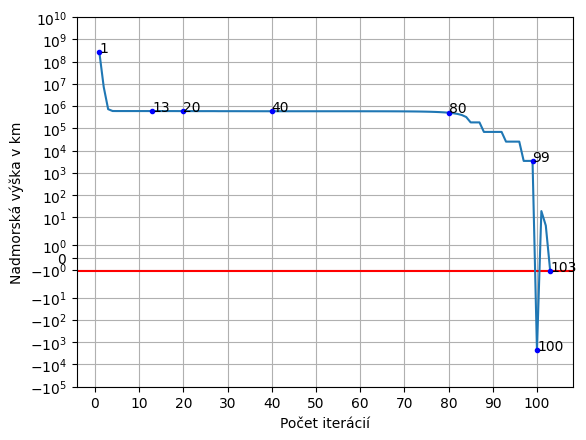

In [ ]:
def visualize_altitudes(alts,interesting,ylim=[-10**5,10**10],log=True,ticks=10):
  fig,ax = plt.subplots()
  ax.axhline(alts[-1],color='r')
  ax.plot([i for i in range(1,len(alts)+1)],alts)

  for i in interesting:
    ax.plot(i,alts[i-1],'.',color='b')
    ax.text(i,alts[i-1] ,i)
  ax.set_xticks(range(0,len(alts),ticks))
  if log:
    ax.set_yscale("symlog")
  ax.set_ylim(ylim)
  ax.set_ylabel("Nadmorská výška v km")
  ax.set_xlabel("Počet iterácií")
  ax.grid(True,'both','both')
print(f"start point altitude: {alts[0]} km")
print(f"100th point altitude: {alts[-4]} km")
visualize_altitudes(alts,interesting)

### Satellites crushing

In [ ]:
s_i = np.array([s1, s2, s3, s4])
t_i = np.array([t1, t2, t3, t4])

start = np.array([0, 0, 0, 50])

s_error = []
t_error = []

results = {}

def errorMaker(i,run,text):
  if i == len(s_i):
    results[text],_,_,_ = (general_3D(np.array(s_error),
               np.array(t_error),
               start,
               epsilon=1e-10,
               iterations_max=1000))
  else:
    if run:
      newtext = text + f"{i+1}"
      s_error.append(s_i[i])
      t_error.append(t_i[i])
    else:
      newtext = text
    for run_i in False,True:
      errorMaker(i+1,run_i,newtext)
    if run:
      s_error.pop()
      t_error.pop()
errorMaker(-1,False,"")

In [ ]:
map = None
for good_satellites,(x,y,z,_) in results.items():
  lati,longt,alt = convert(x,y,z)
  x = [f"{i}" in good_satellites for i in [1,2,3,4]]
  if sum(x) > 3:
    c = "green"
    good_satellites = "x*"

  elif sum(x) > 2:
    c = "orange"
  elif sum(x) > 1:
    c = "lightred"
  elif sum(x) > 0:
    c = "red"
  else:
    c = "black"
    good_satellites = "štart"
  map = plot_circle(lati,longt,text = good_satellites,map=map,color=c,font_size=15)

In [ ]:
for i,xyz in enumerate(s_i,1):
  plot_circle(*convert(*xyz)[:-1],map=map,text=f"sat{i}",color="cyan",font_size=15)

In [ ]:
map

### **Reversed task - generating times of signals for each satellite**

**Eiffel tower** coordinates (312m is the height of tower)

In [ ]:
eiffel_coords = (48.85826,2.2945,312)
eiffel_cartes = np.array(convert_to_cartesian(*eiffel_coords))
map = plot_circle(*eiffel_coords[:-1],text='Eifellová veža',r=3,zoom=17,color="black")
eiffel_cartes

array([0.02639182, 0.65867581, 0.74951651])

**Function** `gen_times`:

**Input parameters**:
* `receiver` - location of the receiver
* `satelites` - locations of satellites

**Returns**:
* function `gen_times` returns send time for each satellite

In [ ]:
def gen_times(receiver,satelites):
  dt = np.random.randint(2,10)
  max_time = norm(np.array(satelites[0]) - receiver) / 0.047
  maxi = 0
  i = 1
  x = [dt]
  for coord in satelites[1:]:
    time = norm(np.array(coord) - receiver) / 0.047
    if time > max_time:
      x.append(dt)
      x[maxi] = time - max_time + dt
      max_time = time
      maxi = i
    else:
      x.append(max_time - time + dt)
    i +=1
  return x

In [ ]:
satelites_coords = [
    [-29,45,578469],
    [0,-96,322483],
    [50,-17,301808],
    [53,48,278251]
    ]

satelites_cartes = np.array([convert_to_cartesian(*coord) for coord in satelites_coords])
gen_times(eiffel_cartes,satelites_cartes)

[np.float64(10.728962176303348),
 9,
 np.float64(36.414886270133145),
 np.float64(30.4962425793801)]

In [ ]:
times = np.array([3.72896,2,29.41489,23.49624])
start = np.array([0.6,-0.7,-0.5,13])
res,_,_,iters = (general_3D(satelites_cartes,
              times,
              start,
              epsilon=1e-10,
              iterations_max=1000))
lat,lon,alt = convert(*res[:-1])
map = plot_circle(lat,lon,map=map,zoom=2,color="green")
map = plot_circle(*convert(*start)[:-1],map=map,zoom=1,color="blue")
display((lat,lon,alt))
display(eiffel_coords)

for i,(lat,lon,_) in enumerate(satelites_coords):
  map = plot_circle(lat,lon,map=map,zoom=1,text=i+1)
display(map)

(np.float64(48.858248069274595),
 np.float64(2.2944887903607403),
 np.float64(312.5385554842651))

(48.85826, 2.2945, 312)